In [3]:
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot  as plt
import matplotlib
import copy

from random import shuffle
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset,ConcatDataset
from torch import nn
from torchvision import datasets,transforms
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D
from DML_COX import *
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Testing doubly robust method for $\theta(z)=\sum_{j=1}^{10}z_j/10$

In [4]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=10
# Non-parameter part
def theta(x):
    return torch.unsqueeze(torch.mean(x,1),1)

# compute E[X|Z]
def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((torch.sin(Z), Z,torch.sin(Z*3)),1) @ A
    return feature_normalize(eta)

# generate the distribution of Z
def dist_Z(N,Z_dim=Z_dim,rho_Z=0.5):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
)

model_theta = nn.Sequential(
    nn.Linear(Z_dim,1),
)

Epoch_XZ=161
lr_XZ=2e-3
Epoch_theta=161
lr_theta=1e-2

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

In [5]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')

# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.MSELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)

uncensoring sample number:  tensor(1319., device='cuda:0')
train E[X|Z,T>t]
epoch: 0 Train_loss:6.24899, epoch: 0 Test_loss:6.08289
epoch: 10 Train_loss:5.23475, epoch: 10 Test_loss:5.14188
epoch: 20 Train_loss:4.02716, epoch: 20 Test_loss:4.03833
epoch: 30 Train_loss:3.33111, epoch: 30 Test_loss:3.39717
epoch: 40 Train_loss:2.93661, epoch: 40 Test_loss:3.01364
epoch: 50 Train_loss:2.62198, epoch: 50 Test_loss:2.73786
epoch: 60 Train_loss:2.31253, epoch: 60 Test_loss:2.45198
epoch: 70 Train_loss:2.04637, epoch: 70 Test_loss:2.21730
epoch: 80 Train_loss:1.82862, epoch: 80 Test_loss:2.03869
epoch: 90 Train_loss:1.65326, epoch: 90 Test_loss:1.89784
epoch: 100 Train_loss:1.52029, epoch: 100 Test_loss:1.78355
epoch: 110 Train_loss:1.42435, epoch: 110 Test_loss:1.70585
epoch: 120 Train_loss:1.36297, epoch: 120 Test_loss:1.66371
epoch: 130 Train_loss:1.29781, epoch: 130 Test_loss:1.61110
epoch: 140 Train_loss:1.25848, epoch: 140 Test_loss:1.58252
epoch: 150 Train_loss:1.22750, epoch: 150 Test

### 双重鲁棒估计

In [6]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')

# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.MSELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              #Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=5e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)


uncensoring sample number:  tensor(1318., device='cuda:0')
train theta(Z)
epoch: 0 Train_loss:4.31404, epoch: 0 Test_loss:4.43814
epoch: 10 Train_loss:4.25505, epoch: 10 Test_loss:4.37779
epoch: 20 Train_loss:4.22733, epoch: 20 Test_loss:4.35095
epoch: 30 Train_loss:4.21593, epoch: 30 Test_loss:4.34023
epoch: 40 Train_loss:4.20970, epoch: 40 Test_loss:4.33301
epoch: 50 Train_loss:4.20629, epoch: 50 Test_loss:4.32810
epoch: 60 Train_loss:4.20468, epoch: 60 Test_loss:4.32592
epoch: 70 Train_loss:4.20369, epoch: 70 Test_loss:4.32526
epoch: 80 Train_loss:4.20305, epoch: 80 Test_loss:4.32494
epoch: 90 Train_loss:4.20261, epoch: 90 Test_loss:4.32456
epoch: 100 Train_loss:4.20228, epoch: 100 Test_loss:4.32425
epoch: 110 Train_loss:4.20203, epoch: 110 Test_loss:4.32406
epoch: 120 Train_loss:4.20184, epoch: 120 Test_loss:4.32400
epoch: 130 Train_loss:4.20171, epoch: 130 Test_loss:4.32403
train E[X|Z,T>t]
epoch: 0 Train_loss:5.99223, epoch: 0 Test_loss:5.90967
epoch: 10 Train_loss:5.08073, epoch

In [7]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


PL Cox bias： tensor([-0.0053,  0.0247], device='cuda:0') bias norm: tensor(0.0253, device='cuda:0')
PL Cox standard error： tensor([0.0577, 0.0589], device='cuda:0')
PL Cox test H_0: β=β_0, p value：0.91342
PL Cox test H_0: β[0]=β_0[0], p value：0.92730
PL Cox test H_0: β[1]=β_0[1], p value：0.67476

DBPL bias： tensor([0.0369, 0.0658], device='cuda:0') DBPL bias： tensor(0.0755, device='cuda:0')
DBPL standard error： tensor([0.0546, 0.0573], device='cuda:0')
DBPL test H_0: β=β_0, p value：0.38379
DBPL test H_0: β[0]=β_0[0], p value：0.49901
DBPL test H_0: β[1]=β_0[1], p value：0.25060


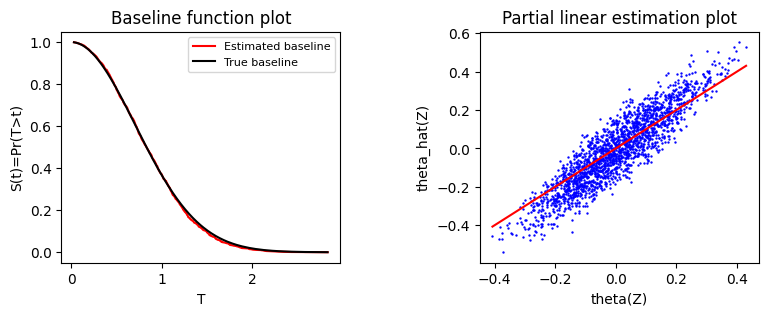

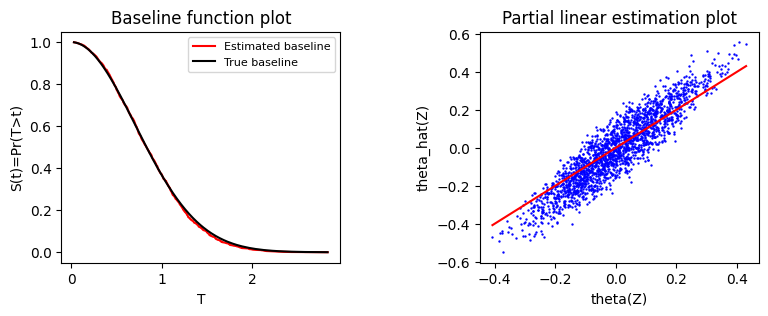

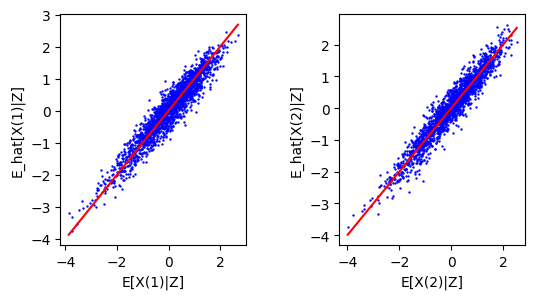

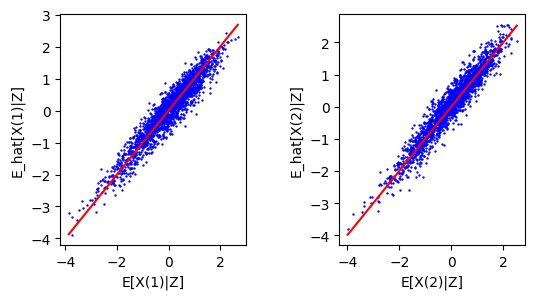

In [7]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new=sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ, Z_new=sim_data_test.Z)

## Testing doubly robust method for $\theta(z)=\exp\{-\sum_{j=1}^{10}z_j^2/2\}$

In [19]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.3])
Z_dim=10
# Non-parameter part
def theta(x):
    return torch.unsqueeze(torch.exp(-torch.norm(x,dim=1)**2/2),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(Z*2), 0.1*Z,torch.sin(Z*6)),1) @ A
    return feature_normalize(eta)

def dist_Z(N,Z_dim=Z_dim,rho_Z=0):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z

# define the neural network framework used to train theta(Z)
model_theta = nn.Sequential(
    nn.Linear(Z_dim,25),
    nn.ReLU(),
    nn.Linear(25,25),
    nn.ReLU(),
    nn.Linear(25,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
)

Epoch_XZ=261
lr_XZ=100e-4
Epoch_theta=261
lr_theta=75e-4


censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

未删失样本数： tensor(1309., device='cuda:4')
train theta:
epoch: 0 Train_loss:4.22982, epoch: 0 Test_loss:4.20993
epoch: 10 Train_loss:4.21761, epoch: 10 Test_loss:4.19877
epoch: 20 Train_loss:4.20862, epoch: 20 Test_loss:4.19180
epoch: 30 Train_loss:4.20190, epoch: 30 Test_loss:4.18874
epoch: 40 Train_loss:4.19515, epoch: 40 Test_loss:4.18466
epoch: 50 Train_loss:4.18834, epoch: 50 Test_loss:4.18081
epoch: 60 Train_loss:4.18156, epoch: 60 Test_loss:4.17849
epoch: 70 Train_loss:4.17483, epoch: 70 Test_loss:4.17708
epoch: 80 Train_loss:4.16824, epoch: 80 Test_loss:4.17689
epoch: 90 Train_loss:4.16193, epoch: 90 Test_loss:4.17785
tensor([ 0.2671, -0.0758])


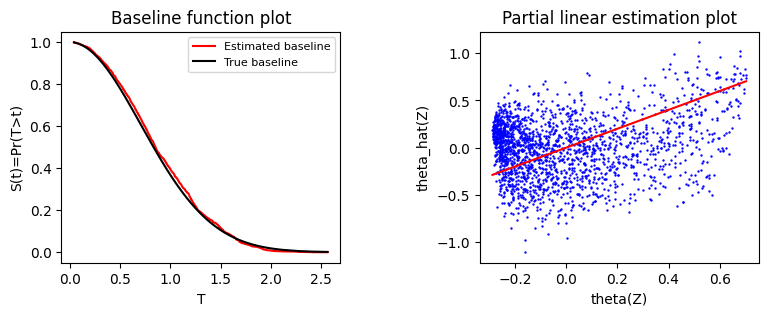

In [7]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
# print('train E[X|Z,T>t]')
# model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.MSELoss(),
#                            model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
#                            Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device, Early_stop= True,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
def Baseline_func(x): return torch.exp(-x**2)
deepSurv.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)

未删失样本数： tensor(1341., device='cuda:4')
train E[X|Z,T>t]
epoch: 0 Train_loss:3.44347, epoch: 0 Test_loss:3.42284
epoch: 10 Train_loss:3.15140, epoch: 10 Test_loss:3.16071
epoch: 20 Train_loss:3.10028, epoch: 20 Test_loss:3.15717
epoch: 30 Train_loss:3.06702, epoch: 30 Test_loss:3.15249
epoch: 40 Train_loss:3.03275, epoch: 40 Test_loss:3.15419
epoch: 50 Train_loss:2.99562, epoch: 50 Test_loss:3.15954


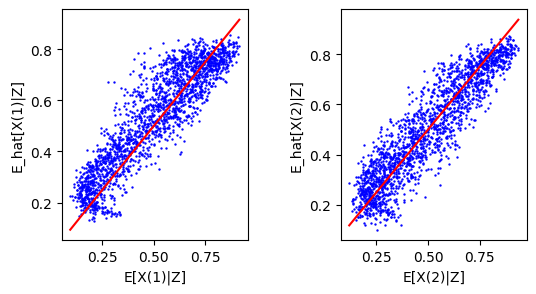

In [23]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.MSELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)
model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)

### Doubly robust fitting

In [20]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')

# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.MSELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)


net = CustomNet(h_dims=[1, 50,50,50, len(beta)], g_dims=[Z_dim,50,50,50, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=8e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)

未删失样本数： tensor(1313., device='cuda:4')
train theta(Z)
epoch: 0 Train_loss:4.21365, epoch: 0 Test_loss:4.06636
epoch: 10 Train_loss:4.18973, epoch: 10 Test_loss:4.04735
epoch: 20 Train_loss:4.17962, epoch: 20 Test_loss:4.04203
epoch: 30 Train_loss:4.17257, epoch: 30 Test_loss:4.03912
epoch: 40 Train_loss:4.16430, epoch: 40 Test_loss:4.04303
epoch: 50 Train_loss:4.15610, epoch: 50 Test_loss:4.05061
train E[X|Z,T>t]
epoch: 0 Train_loss:6.26521, epoch: 0 Test_loss:5.86078
epoch: 10 Train_loss:3.34029, epoch: 10 Test_loss:3.42523
epoch: 20 Train_loss:2.91790, epoch: 20 Test_loss:2.97077
epoch: 30 Train_loss:2.76044, epoch: 30 Test_loss:2.89630
epoch: 40 Train_loss:2.64095, epoch: 40 Test_loss:2.86381
epoch: 50 Train_loss:2.53455, epoch: 50 Test_loss:2.82735
epoch: 60 Train_loss:2.35161, epoch: 60 Test_loss:2.77162
epoch: 70 Train_loss:2.15960, epoch: 70 Test_loss:2.68128
epoch: 80 Train_loss:2.00087, epoch: 80 Test_loss:2.62137
epoch: 90 Train_loss:1.88182, epoch: 90 Test_loss:2.56127
epoch

In [ ]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))

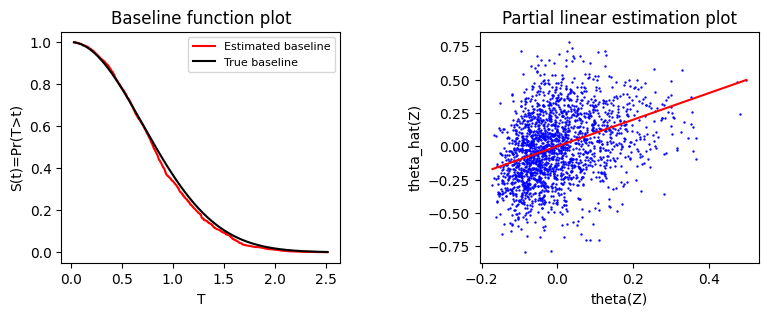

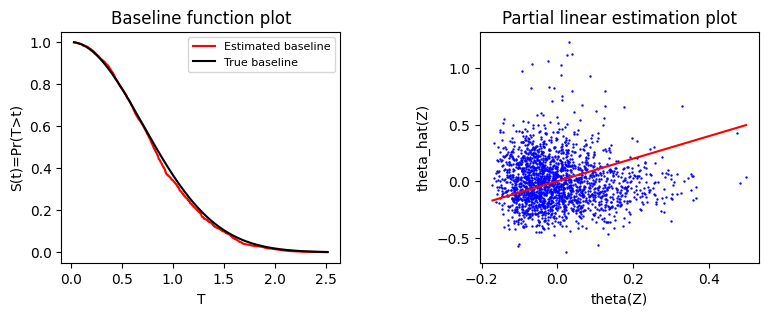

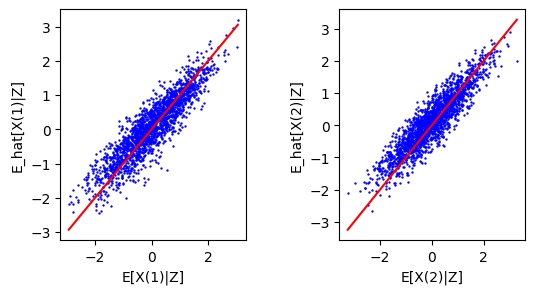

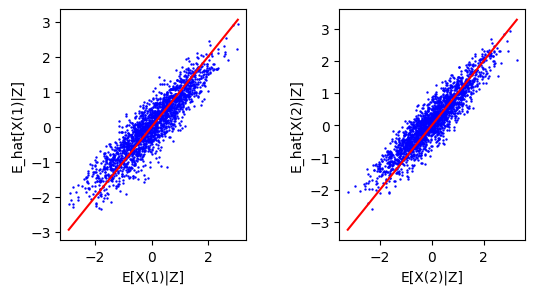

In [21]:
Baseline_func = lambda x: torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)

In [10]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=6e-3,print_state=True)
print('直接估计标准差：',torch.sqrt(torch.diag(var_est_naive)))

Epoch 10, Train Loss: 1.689628, Val Loss: 1.828878
Epoch 20, Train Loss: 1.679025, Val Loss: 1.818710
Epoch 30, Train Loss: 1.678726, Val Loss: 1.818483
Epoch 40, Train Loss: 1.678915, Val Loss: 1.818537
直接估计标准差： tensor([0.0262, 0.0256], device='cuda:4')


## Testing doubly robust method for $\theta(z)=\sin\{-\sum_{j=1}^{10}z_j^2/4\}$

In [8]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=10
# Non-parameter part
def theta(x):
    return torch.unsqueeze(torch.sin(-torch.norm(x,dim=1)**2/4),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(2*Z), 0.1*Z,torch.sin(6*Z)),1) @ A
    return feature_normalize(eta)

def dist_Z(N,Z_dim=Z_dim,rho_Z=0):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
)

# define the neural network framework used to train theta(Z)
model_theta = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    # nn.Linear(25,25),
    # nn.ReLU(),
    nn.Linear(100,1),
)


Epoch_XZ=1101
lr_XZ=100e-4
Epoch_theta=2201
lr_theta=60e-4

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

uncensoring sample number:  tensor(1326., device='cuda:0')
train E[X|Z,T>t]
epoch: 0 Train_loss:6.09739, epoch: 0 Test_loss:5.96557
epoch: 10 Train_loss:3.51443, epoch: 10 Test_loss:3.51398
epoch: 20 Train_loss:3.01558, epoch: 20 Test_loss:3.17015
epoch: 30 Train_loss:2.81402, epoch: 30 Test_loss:3.08595
epoch: 40 Train_loss:2.68957, epoch: 40 Test_loss:2.99836
epoch: 50 Train_loss:2.54655, epoch: 50 Test_loss:2.94459
epoch: 60 Train_loss:2.37246, epoch: 60 Test_loss:2.85006
epoch: 70 Train_loss:2.17033, epoch: 70 Test_loss:2.74671
epoch: 80 Train_loss:2.02365, epoch: 80 Test_loss:2.69425
epoch: 90 Train_loss:1.89834, epoch: 90 Test_loss:2.67864
epoch: 100 Train_loss:1.78223, epoch: 100 Test_loss:2.65311
epoch: 110 Train_loss:1.68857, epoch: 110 Test_loss:2.64149
epoch: 120 Train_loss:1.62712, epoch: 120 Test_loss:2.64421


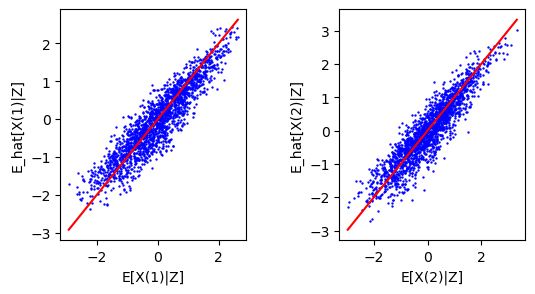

In [9]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.MSELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)

train theta:
epoch: 0 Train_loss:4.25614, epoch: 0 Test_loss:4.37692
epoch: 10 Train_loss:4.20236, epoch: 10 Test_loss:4.34526
epoch: 20 Train_loss:4.19341, epoch: 20 Test_loss:4.34563
epoch: 30 Train_loss:4.18449, epoch: 30 Test_loss:4.33773
epoch: 40 Train_loss:4.17744, epoch: 40 Test_loss:4.33679
epoch: 50 Train_loss:4.17011, epoch: 50 Test_loss:4.33808
tensor([-0.1089, -0.0186])


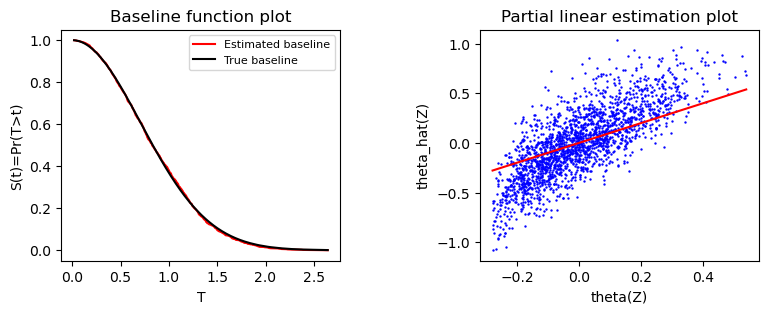

In [10]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device, Early_stop= True,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta.cpu())
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
def Baseline_func(x): return torch.exp(-x**2)
deepSurv.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)

### Doubly robust fitting

In [11]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')

# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.MSELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=7e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)

uncensoring sample number:  tensor(1305., device='cuda:0')
train theta(Z)
epoch: 0 Train_loss:4.31211, epoch: 0 Test_loss:4.26844
epoch: 10 Train_loss:4.23275, epoch: 10 Test_loss:4.20673
epoch: 20 Train_loss:4.21567, epoch: 20 Test_loss:4.19216
epoch: 30 Train_loss:4.20451, epoch: 30 Test_loss:4.18251
epoch: 40 Train_loss:4.19664, epoch: 40 Test_loss:4.17886
epoch: 50 Train_loss:4.18840, epoch: 50 Test_loss:4.17451
epoch: 60 Train_loss:4.18066, epoch: 60 Test_loss:4.17138
epoch: 70 Train_loss:4.17344, epoch: 70 Test_loss:4.16989
epoch: 80 Train_loss:4.16650, epoch: 80 Test_loss:4.16979
epoch: 90 Train_loss:4.16010, epoch: 90 Test_loss:4.17096
train E[X|Z,T>t]
epoch: 0 Train_loss:6.41238, epoch: 0 Test_loss:5.77985
epoch: 10 Train_loss:3.79364, epoch: 10 Test_loss:3.74318
epoch: 20 Train_loss:3.17569, epoch: 20 Test_loss:3.21142
epoch: 30 Train_loss:2.92235, epoch: 30 Test_loss:3.01091
epoch: 40 Train_loss:2.77989, epoch: 40 Test_loss:2.93366
epoch: 50 Train_loss:2.63842, epoch: 50 Tes

In [12]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


PL Cox bias： tensor([ 0.0496, -0.0515], device='cuda:0') bias norm: tensor(0.0715, device='cuda:0')
PL Cox standard error： tensor([0.0442, 0.0472], device='cuda:0')
PL Cox test H_0: β=β_0, p value：0.35833
PL Cox test H_0: β[0]=β_0[0], p value：0.26205
PL Cox test H_0: β[1]=β_0[1], p value：0.27471

DBPL bias： tensor([0.0697, 0.0133], device='cuda:0') DBPL bias： tensor(0.0709, device='cuda:0')
DBPL standard error： tensor([0.0428, 0.0435], device='cuda:0')
DBPL test H_0: β=β_0, p value：0.23912
DBPL test H_0: β[0]=β_0[0], p value：0.10329
DBPL test H_0: β[1]=β_0[1], p value：0.75937


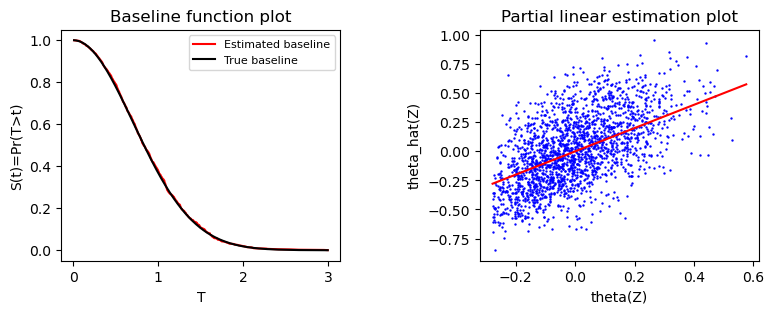

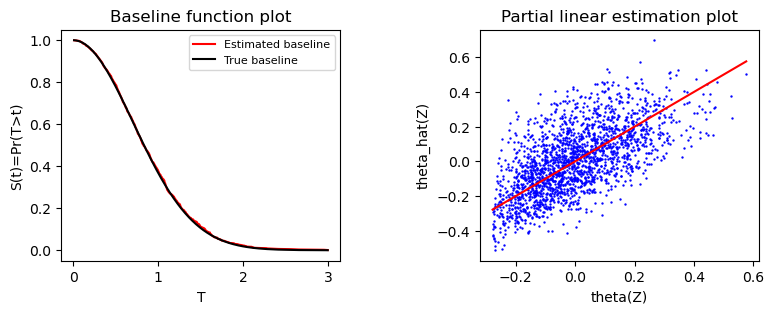

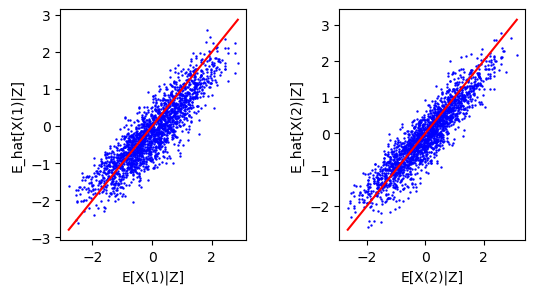

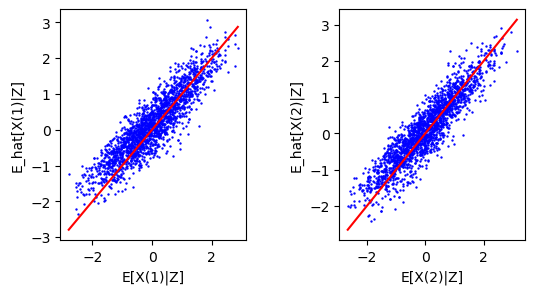

In [13]:
Baseline_func = lambda x: torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func, Z_new = sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ, Z_new = sim_data_test.Z)

## Testing doubly robust method for $\theta(z)=z_1^2 + 2z_2^2+ z_3^3+\sqrt{z_4+1}+\log(z_5+1)-8.6$

In [7]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=5
# Non-parameter part
def theta(x):
    return torch.unsqueeze(x[:,0]**2 + 2*x[:,1]**2 + x[:,2]**3 + torch.sqrt(x[:,3]+1)+torch.log(x[:,4]+1)-8.6,1)
    # return torch.unsqueeze(torch.sqrt(x[:,3]+1)+x[:,4]/5,1)
    #return torch.unsqueeze(torch.mean(x,1),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(2*Z), 0.1*Z,torch.sin(6*Z)),1) @ A
    return feature_normalize(eta)

def dist_Z(N,Z_dim=Z_dim,rho_Z=0):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z


# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
)

# define the neural network framework used to train theta(Z)
model_theta = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,1),
)


Epoch_XZ=1101
lr_XZ=100e-4
Epoch_theta=2201
lr_theta=50e-4

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

In [8]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.MSELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)

未删失样本数： tensor(1286., device='cuda:4')
train E[X|Z,T>t]
epoch: 0 Train_loss:6.38553, epoch: 0 Test_loss:6.09095
epoch: 10 Train_loss:4.13252, epoch: 10 Test_loss:3.92617
epoch: 20 Train_loss:2.61701, epoch: 20 Test_loss:2.84796
epoch: 30 Train_loss:2.44466, epoch: 30 Test_loss:2.62502
epoch: 40 Train_loss:2.33801, epoch: 40 Test_loss:2.53427
epoch: 50 Train_loss:2.25348, epoch: 50 Test_loss:2.45767
epoch: 60 Train_loss:2.17179, epoch: 60 Test_loss:2.39351
epoch: 70 Train_loss:2.09085, epoch: 70 Test_loss:2.32165
epoch: 80 Train_loss:2.00954, epoch: 80 Test_loss:2.25695
epoch: 90 Train_loss:1.92858, epoch: 90 Test_loss:2.19049
epoch: 100 Train_loss:1.84695, epoch: 100 Test_loss:2.12201
epoch: 110 Train_loss:1.76620, epoch: 110 Test_loss:2.05054
epoch: 120 Train_loss:1.68946, epoch: 120 Test_loss:1.98110
epoch: 130 Train_loss:1.62388, epoch: 130 Test_loss:1.92263
epoch: 140 Train_loss:1.56366, epoch: 140 Test_loss:1.87139
epoch: 150 Train_loss:1.51060, epoch: 150 Test_loss:1.81876
epoch:

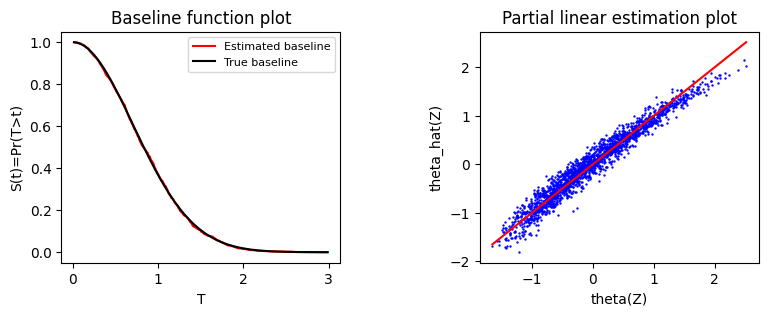

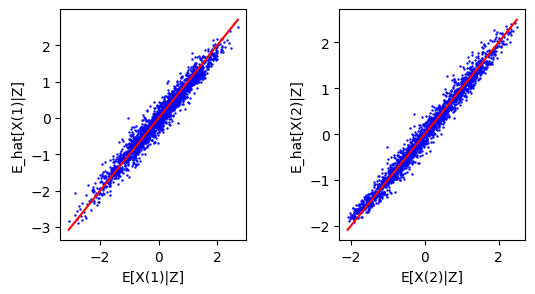

In [9]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
deepSurv.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

### Doubly robust fitting

In [10]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.MSELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=5e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)

未删失样本数： tensor(1255., device='cuda:4')
train theta(Z)
epoch: 0 Train_loss:4.41014, epoch: 0 Test_loss:4.54352
epoch: 10 Train_loss:4.06682, epoch: 10 Test_loss:4.24544
epoch: 20 Train_loss:4.03114, epoch: 20 Test_loss:4.22515
epoch: 30 Train_loss:4.00747, epoch: 30 Test_loss:4.20391
epoch: 40 Train_loss:3.98561, epoch: 40 Test_loss:4.18726
epoch: 50 Train_loss:3.96708, epoch: 50 Test_loss:4.17022
epoch: 60 Train_loss:3.95101, epoch: 60 Test_loss:4.15727
epoch: 70 Train_loss:3.93660, epoch: 70 Test_loss:4.14448
epoch: 80 Train_loss:3.92375, epoch: 80 Test_loss:4.13528
epoch: 90 Train_loss:3.91273, epoch: 90 Test_loss:4.12807
epoch: 100 Train_loss:3.90345, epoch: 100 Test_loss:4.12322
epoch: 110 Train_loss:3.89546, epoch: 110 Test_loss:4.12053
epoch: 120 Train_loss:3.88775, epoch: 120 Test_loss:4.12001
epoch: 130 Train_loss:3.88067, epoch: 130 Test_loss:4.12098
train E[X|Z,T>t]
epoch: 0 Train_loss:6.52191, epoch: 0 Test_loss:6.19247
epoch: 10 Train_loss:3.10369, epoch: 10 Test_loss:3.085

In [ ]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))

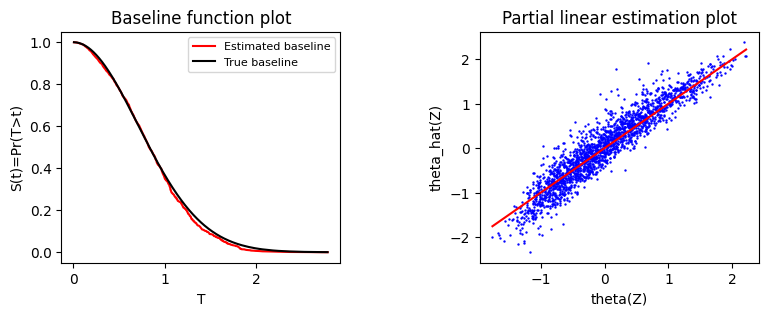

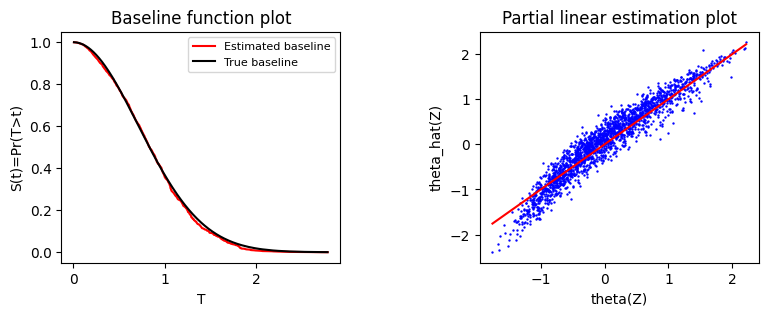

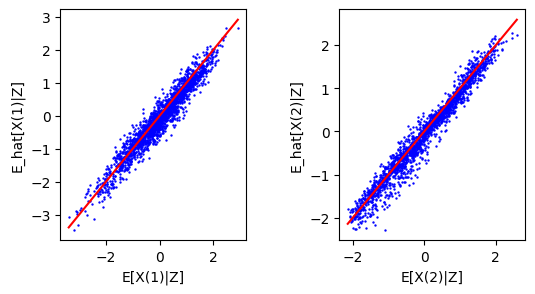

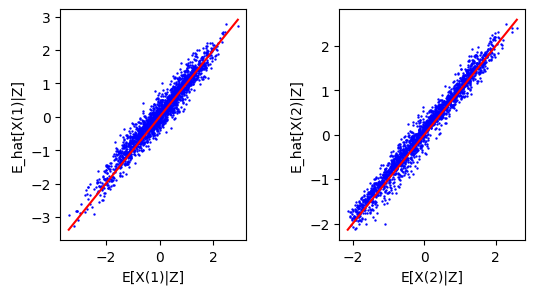

In [9]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

## Testing doubly robust method for $\theta(x)=x_1^2x_2^2+\log(x_3+1)+\sqrt{x_4x_5+1}+e^{x_5/2}-8.2$

In [28]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=5
# Non-parameter part
def theta(x):
    return torch.unsqueeze(x[:,0]**2 * x[:,1]**2 + torch.log((x[:,2]+1)**2)/2 + torch.sqrt(x[:,3]*x[:,4]+1)+torch.exp(x[:,4]/2)-8.2,1)
    # return torch.unsqueeze(torch.sqrt(x[:,3]+1)+x[:,4]/5,1)
    #return torch.unsqueeze(torch.mean(x,1),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(Z*2), 0.1*Z,torch.sin(Z*6)),1) @ A
    return feature_normalize(eta)


def dist_Z(N,Z_dim=Z_dim,rho_Z=0):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z


# define the neural network framework used to train theta(Z)
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_theta = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    # nn.Linear(100,100),
    # nn.ReLU(),
    nn.Linear(100,1),
)




Epoch_XZ=1101
lr_XZ=100e-4
Epoch_theta=2201
lr_theta=80e-4

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

In [20]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')



# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.MSELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)

未删失样本数： tensor(1312., device='cuda:4')
train E[X|Z,T>t]
epoch: 0 Train_loss:3.46870, epoch: 0 Test_loss:3.43876
epoch: 10 Train_loss:3.21541, epoch: 10 Test_loss:3.21759
epoch: 20 Train_loss:3.10540, epoch: 20 Test_loss:3.17690
epoch: 30 Train_loss:3.06925, epoch: 30 Test_loss:3.14943
epoch: 40 Train_loss:3.03512, epoch: 40 Test_loss:3.15014
epoch: 50 Train_loss:2.99906, epoch: 50 Test_loss:3.15247
train theta:
epoch: 0 Train_loss:4.26842, epoch: 0 Test_loss:4.15120
epoch: 10 Train_loss:4.23185, epoch: 10 Test_loss:4.11732
epoch: 20 Train_loss:4.22178, epoch: 20 Test_loss:4.10839
epoch: 30 Train_loss:4.21303, epoch: 30 Test_loss:4.10320
epoch: 40 Train_loss:4.20567, epoch: 40 Test_loss:4.10021
epoch: 50 Train_loss:4.19832, epoch: 50 Test_loss:4.09571
epoch: 60 Train_loss:4.19160, epoch: 60 Test_loss:4.09327
epoch: 70 Train_loss:4.18561, epoch: 70 Test_loss:4.09124
epoch: 80 Train_loss:4.18034, epoch: 80 Test_loss:4.08967
epoch: 90 Train_loss:4.17588, epoch: 90 Test_loss:4.08888
epoch: 

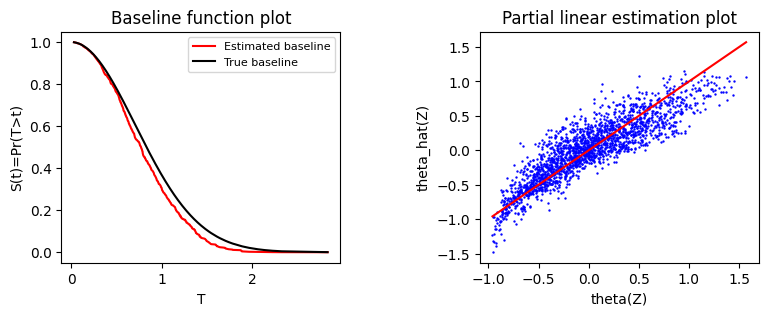

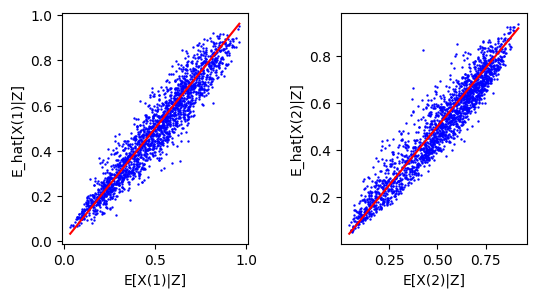

In [52]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
deepSurv.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

### Doubly robust fitting

In [44]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.MSELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=5e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)

未删失样本数： tensor(1365., device='cuda:4')
train theta(Z)
epoch: 0 Train_loss:4.64116, epoch: 0 Test_loss:4.40791
epoch: 10 Train_loss:4.46232, epoch: 10 Test_loss:4.25962
epoch: 20 Train_loss:4.44256, epoch: 20 Test_loss:4.24634
epoch: 30 Train_loss:4.41635, epoch: 30 Test_loss:4.22638
epoch: 40 Train_loss:4.39964, epoch: 40 Test_loss:4.21605
epoch: 50 Train_loss:4.38704, epoch: 50 Test_loss:4.21013
epoch: 60 Train_loss:4.37836, epoch: 60 Test_loss:4.20561
epoch: 70 Train_loss:4.37242, epoch: 70 Test_loss:4.20368
epoch: 80 Train_loss:4.36810, epoch: 80 Test_loss:4.20220
epoch: 90 Train_loss:4.36490, epoch: 90 Test_loss:4.20159
epoch: 100 Train_loss:4.36223, epoch: 100 Test_loss:4.20066
epoch: 110 Train_loss:4.35988, epoch: 110 Test_loss:4.20022
epoch: 120 Train_loss:4.35758, epoch: 120 Test_loss:4.20077
train E[X|Z,T>t]
epoch: 0 Train_loss:6.23902, epoch: 0 Test_loss:5.76303
epoch: 10 Train_loss:2.97056, epoch: 10 Test_loss:2.80961
epoch: 20 Train_loss:2.56203, epoch: 20 Test_loss:2.47330

In [ ]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))

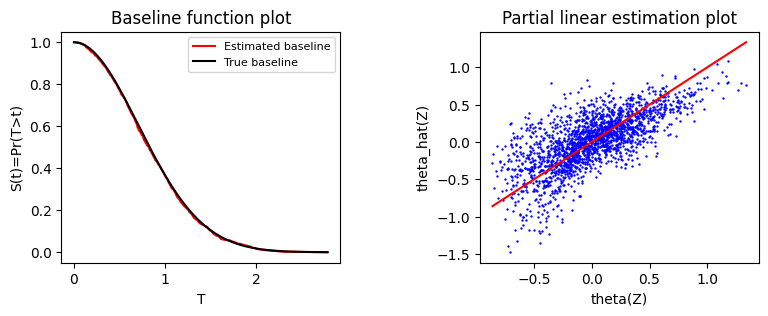

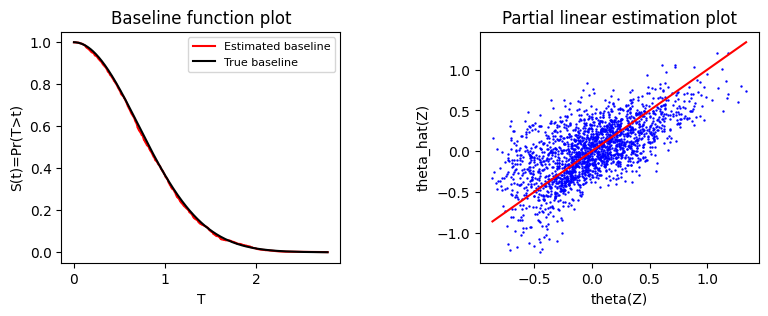

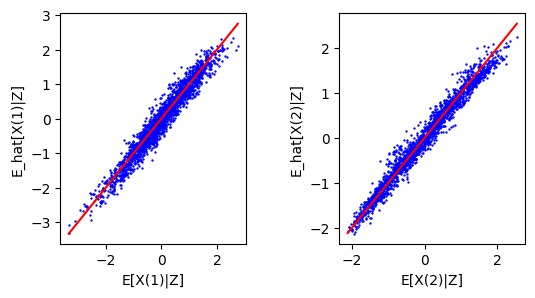

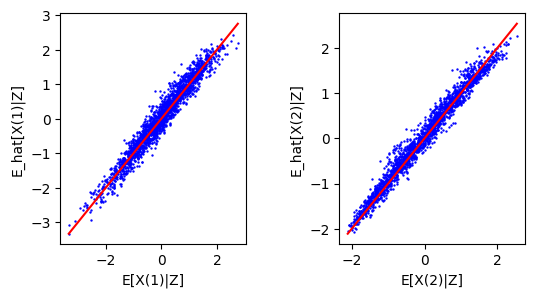

In [45]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

## Testing doubly robust method for $\theta(x)=\{x_1^2x_2^2+\log(x_3+1)+\sqrt{x_4x_5+1}+e^{x_5/2}\}^2/20-6$

In [46]:
# sampling number
N=2000
# parameter part
beta = torch.tensor([-0.2,0.1])
Z_dim=5
# Non-parameter part
def theta(x):
    return torch.unsqueeze((x[:,0]**2 * x[:,1]**2 + torch.log((x[:,2]+1)**2)/2 + torch.sqrt(x[:,3]*x[:,4]+1)+torch.exp(x[:,4]/2))**2/20,1)
    # return torch.unsqueeze(torch.sqrt(x[:,3]+1)+x[:,4]/5,1)
    #return torch.unsqueeze(torch.mean(x,1),1)

def E_XZ(Z,X_dim):
    np.random.seed(204)
    A = torch.tensor(np.random.normal(0,1,size=( 3*Z.shape[1], X_dim))).float()
    eta = torch.cat((2*torch.sin(Z*2), 0.2*Z,torch.sin(Z*6)),1) @ A
    return feature_normalize(eta)

def dist_Z(N,Z_dim=Z_dim,rho_Z=0):
    mean = torch.zeros(Z_dim)
    covariance_matrix = torch.zeros((Z_dim, Z_dim))
    
    for i in range(Z_dim):
        for j in range(Z_dim):
            covariance_matrix[i, j] = rho_Z**np.abs(i-j)
    multivariate_normal = MultivariateNormal(mean, covariance_matrix)
    Z = multivariate_normal.sample((N,))
    
    normal_dist = Normal(mean, 1)
    Z = normal_dist.cdf(Z)
    return Z

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(Z_dim,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,len(beta)),
)

# define the neural network framework used to train theta(Z)
model_theta = nn.Sequential(
    nn.Linear(Z_dim,50),
    nn.ReLU(),
    # nn.Linear(50,50),
    # nn.ReLU(),
    nn.Linear(50,1),
)

Epoch_XZ=1101
lr_XZ=100e-4
Epoch_theta=2201
lr_theta=120e-4

censor_ave=2
accuray=0.1
cut=3

### Nuisance function fitting

In [142]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')


T_interval = torch.quantile(sim_data.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ1 = fit_XZ_complete(sim_data,T_interval,device=device,loss_fn=nn.MSELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=sim_data_test)

print('train theta:')
beta_est,theta_est = fit_CoxPH(sim_data,device=device,
                               model=model_theta, lr=lr_theta, Epoch=Epoch_theta,
                               Test_set=sim_data_test)
print(beta_est.cpu()-beta)

train E[X|Z,T>t]
epoch: 0 Train_loss:3.47119, epoch: 0 Test_loss:3.43672
epoch: 10 Train_loss:3.22037, epoch: 10 Test_loss:3.16514
epoch: 20 Train_loss:3.13753, epoch: 20 Test_loss:3.09656
epoch: 30 Train_loss:3.10190, epoch: 30 Test_loss:3.08089
epoch: 40 Train_loss:3.06705, epoch: 40 Test_loss:3.06175
epoch: 50 Train_loss:3.03496, epoch: 50 Test_loss:3.05689
epoch: 60 Train_loss:3.00182, epoch: 60 Test_loss:3.05631
epoch: 70 Train_loss:2.97019, epoch: 70 Test_loss:3.06234
train theta:
epoch: 0 Train_loss:4.03919, epoch: 0 Test_loss:3.84702
epoch: 10 Train_loss:4.02116, epoch: 10 Test_loss:3.83034
epoch: 20 Train_loss:4.01380, epoch: 20 Test_loss:3.82351
epoch: 30 Train_loss:4.01217, epoch: 30 Test_loss:3.82219
epoch: 40 Train_loss:4.00974, epoch: 40 Test_loss:3.82128
epoch: 50 Train_loss:4.00751, epoch: 50 Test_loss:3.82071
epoch: 60 Train_loss:4.00520, epoch: 60 Test_loss:3.81990
epoch: 70 Train_loss:4.00294, epoch: 70 Test_loss:3.81935
epoch: 80 Train_loss:4.00064, epoch: 80 Test_l

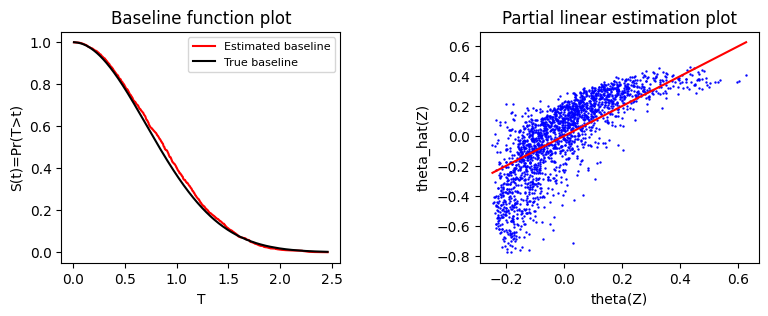

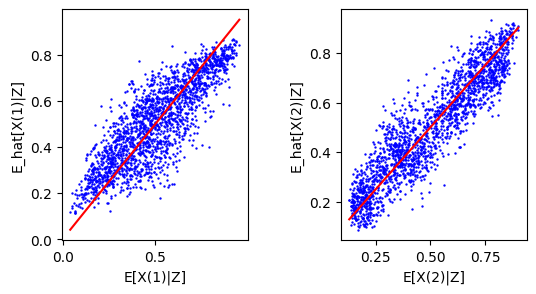

In [143]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv = DeepSurv(sim_data,beta_est,theta_est,device)
deepSurv.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

### Doubly robust fitting

In [47]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')


# output uncensoring number
print('uncensoring sample number: ',torch.sum(sim_data.D))

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(sim_data, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= sim_data_test,loss_XZ=nn.MSELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=7e-3,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)


未删失样本数： tensor(1332., device='cuda:4')
train theta(Z)
epoch: 0 Train_loss:4.34555, epoch: 0 Test_loss:4.41851
epoch: 10 Train_loss:4.28718, epoch: 10 Test_loss:4.37399
epoch: 20 Train_loss:4.26938, epoch: 20 Test_loss:4.36510
epoch: 30 Train_loss:4.25834, epoch: 30 Test_loss:4.36130
epoch: 40 Train_loss:4.25063, epoch: 40 Test_loss:4.35851
epoch: 50 Train_loss:4.24485, epoch: 50 Test_loss:4.35645
epoch: 60 Train_loss:4.24051, epoch: 60 Test_loss:4.35631
epoch: 70 Train_loss:4.23725, epoch: 70 Test_loss:4.35793
train E[X|Z,T>t]
epoch: 0 Train_loss:6.21624, epoch: 0 Test_loss:5.63986
epoch: 10 Train_loss:2.84219, epoch: 10 Test_loss:2.66000
epoch: 20 Train_loss:2.46270, epoch: 20 Test_loss:2.42955
epoch: 30 Train_loss:2.26324, epoch: 30 Test_loss:2.28298
epoch: 40 Train_loss:2.06972, epoch: 40 Test_loss:2.17137
epoch: 50 Train_loss:1.90194, epoch: 50 Test_loss:2.04647
epoch: 60 Train_loss:1.75179, epoch: 60 Test_loss:1.96049
epoch: 70 Train_loss:1.62801, epoch: 70 Test_loss:1.81404
epoch

In [ ]:
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))

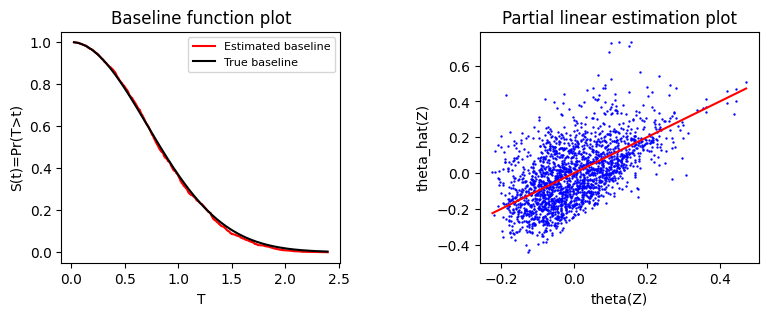

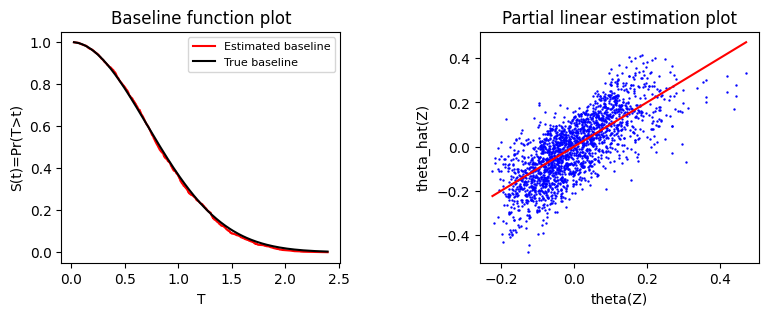

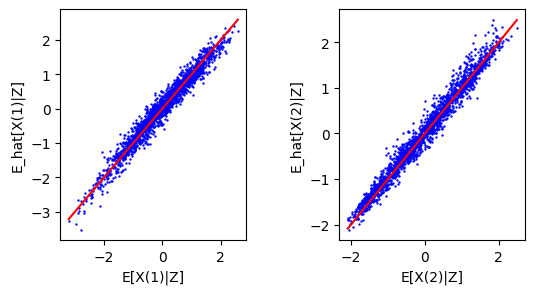

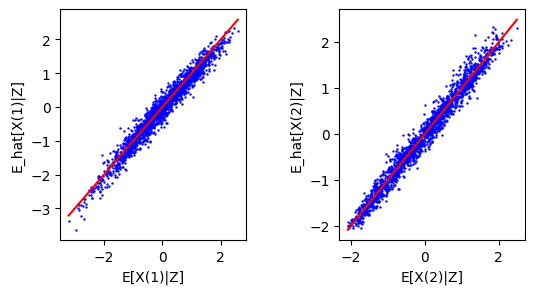

In [48]:
def Baseline_func(x): return torch.exp(-x**2)
deepSurv1.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
deepSurv2.plot(theta=theta,Baseline=Baseline_func,Z_new=sim_data_test.Z)
model_XZ1.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)
model_XZ2.plot2(sim_data,E_XZ=E_XZ,Z_new=sim_data_test.Z)

In [41]:
# simulate data
sim_data = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')
sim_data_test = sim_survival(N,beta.cpu(),theta,device=device,E_XZ=E_XZ,dist_Z=dist_Z,cut=cut,censor_ave=censor_ave,X_type='gaussian')

net = CustomNet(h_dims=[1, 50,100,100, len(beta)], g_dims=[Z_dim,50,100,100, len(beta)])
var_est_naive = fit_variance(sim_data, net, device=device, lr=7e-3,print_state=True)
print('naive standard error:',torch.sqrt(torch.diag(var_est_naive)))

Epoch 10, Train Loss: 0.684641, Val Loss: 0.685287
Epoch 20, Train Loss: 0.596563, Val Loss: 0.642989
Epoch 30, Train Loss: 0.503826, Val Loss: 0.589867
Epoch 40, Train Loss: 0.430249, Val Loss: 0.516494
Epoch 50, Train Loss: 0.372611, Val Loss: 0.522409
直接估计标准差： tensor([0.0460, 0.0513], device='cuda:4')
